### Student Name : Stephen Boyle
#### Student ID : 24239151

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.cluster import DBSCAN
from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from sklearn.impute import SimpleImputer

from sklearn.metrics import silhouette_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.manifold import TSNE  
import seaborn as sns


In [73]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

## Task 1

In [74]:
# Load dataset
df = pd.read_csv("bank.csv")

# Separate features and target
features = df.drop(columns=["subscribed"])
target = df["subscribed"]

# drop 'duration' column from features
features = features.drop(columns=["duration"])

In [75]:
# Identify numeric and categorical columns based on your dataset
numeric_standard_features = ['age', 'day', 'campaign', 'pdays', 'previous']
categorical_features_binary = ['default', 'housing', 'loan']
categorical_features_multiclass = ['job', 'marital', 'contact', 'poutcome']

In [76]:
class EducationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column='education'):
        self.column = column
        self.mapping = {
            'unknown': 0,
            'primary': 1,
            'secondary': 2,
            'tertiary': 3
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Fill missing values with 'unknown'
        X[self.column] = X[self.column].fillna('unknown')

        # Create binary feature
        X[f'{self.column}_level_unknown'] = (X[self.column] == 'unknown').astype(int)

        # Map education to numerical
        X[self.column] = X[self.column].map(self.mapping)

        return X

In [77]:
class MonthTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column='month'):
        self.column = column
        self.month_order = {
            'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
            'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Map months to numerical values
        X[self.column] = X[self.column].map(self.month_order)

        # Add sine and cosine transformations
        X[f'{self.column}_sin'] = np.sin(2 * np.pi * X[self.column] / 12)
        X[f'{self.column}_cos'] = np.cos(2 * np.pi * X[self.column] / 12)

        return X

In [78]:
class ContactWeekdayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, day_column='day', month_column='month'):
        self.day_column = day_column
        self.month_column = month_column
        self.month_map = {
            'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
            'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Combine day and month columns into a single column
        contact_dates = X[self.day_column].astype(str) + '_' + X[self.month_column]

        # Parse contact dates to weekdays
        def parse_date_to_weekday(date_str):
            day_str, month_str = date_str.split('_')
            day = int(day_str)
            month = self.month_map[month_str]
            dt = datetime(2022, month, day)  # Use an arbitrary year
            return dt.weekday()

        X['contact_weekday'] = contact_dates.apply(parse_date_to_weekday)

        return X

In [79]:
# custom handling of balance, using minmax scaling
def custom_balance_scaling(X):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

# Replace missing categorical values with 'unknown' category
df[categorical_features_multiclass] = df[categorical_features_multiclass].fillna('unknown')

# Define preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

binary_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Define preprocessing for multi-category categorical features (one-hot encoding)
multi_categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [80]:
# Combine preprocessing in ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('custom_balance', FunctionTransformer(custom_balance_scaling), ['balance']),
        ('num', numeric_transformer, numeric_standard_features),
        ('multi_cat', multi_categorical_transformer, categorical_features_multiclass),
        ('binary_cat', binary_categorical_transformer, categorical_features_binary),
    ])

feature_engineering = Pipeline(steps=[
    ('education_transformer', EducationTransformer()),    
    ('contact_weekday_transformer', ContactWeekdayTransformer()),  
    ('month_transformer', MonthTransformer())
])

engineered_features = feature_engineering.fit_transform(features)

# count the features after feature engineering
print("Number of features after feature engineering:", engineered_features.shape[1])

Number of features after feature engineering: 19


## Task 2

#### Step 1 - test pipeline with Arbitrary value for k
Build pipeline and pick an arbitrary value for k

In [81]:
# pick an arbitrary number of clusters for KMeans
k = 2

pipeline = Pipeline(steps=[        
    ('preprocessor', preprocessor), 
    ('kmeans', KMeans(n_clusters=k, random_state=42))
])

clustering_model = pipeline.fit(engineered_features)

cluster_labels = clustering_model['kmeans'].labels_
cluster_centers = clustering_model['kmeans'].cluster_centers_

preprocessed_data = clustering_model['preprocessor'].transform(engineered_features)

# Calculate silhouette score for the chosen k
final_silhouette_score = silhouette_score(preprocessed_data, cluster_labels)
print(f"Silhouette score for k={k}: {final_silhouette_score:.4f}")






Silhouette score for k=2: 0.1378


#### Step 2 - Find best value for k
* Loop kmeans testing through a range of values for k, track silhouette scores
* Plot SSE ouput to support elbow method
* Plot Silhouette scores for values of k


k=2: Silhouette Score=0.1378, Inertia=13510.44, Inertia Delta=None
k=3: Silhouette Score=0.1301, Inertia=12503.29, Inertia Delta=1007.1539174149566
k=4: Silhouette Score=0.1596, Inertia=11043.00, Inertia Delta=1460.2883174248218
k=5: Silhouette Score=0.1617, Inertia=10057.75, Inertia Delta=985.2504902171804
k=6: Silhouette Score=0.1693, Inertia=9491.63, Inertia Delta=566.121763209323
k=7: Silhouette Score=0.1570, Inertia=8991.85, Inertia Delta=499.7755690914819
k=8: Silhouette Score=0.1382, Inertia=8725.53, Inertia Delta=266.3281724100525
k=9: Silhouette Score=0.1362, Inertia=8387.54, Inertia Delta=337.9819722739667
k=10: Silhouette Score=0.1201, Inertia=8250.94, Inertia Delta=136.60566787858988
Best k : 6.  Based on silhouette score: 0.1693


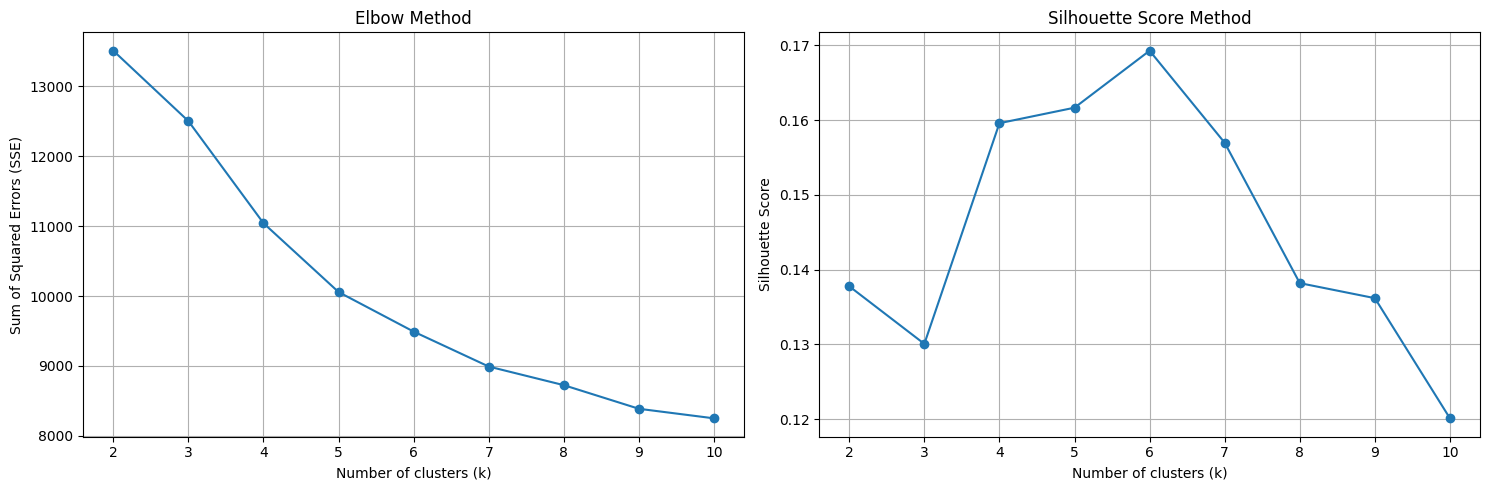

In [82]:
max_k = 10  # Define the maximum number of clusters to evaluate

sse = []
silhouette_scores = []
k_values = range(2, max_k + 1)  # Start from 2 as silhouette requires at least 2 clusters

previous_inertia = None  # Initialize previous inertia value

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(preprocessed_data)
    
    # Get inertia (sum of squared distances)
    inertia = kmeans.inertia_
    sse.append(inertia)
    
    # Calculate silhouette score
    labels = kmeans.labels_
    sil_score = silhouette_score(preprocessed_data, labels)
    silhouette_scores.append(sil_score)
    
    # Calculate inertia delta (difference between consecutive inertia values)
    inertia_delta = None if previous_inertia is None else previous_inertia - inertia
    previous_inertia = inertia  # Update previous inertia
    
    print(f"k={k}: Silhouette Score={sil_score:.4f}, Inertia={inertia:.2f}, Inertia Delta={inertia_delta}")


best_k = k_values[np.argmax(silhouette_scores)]  # Find the best k based on silhouette score
print(f"Best k : {best_k}.  Based on silhouette score: {silhouette_scores[np.argmax(silhouette_scores)]:.4f}")

# Plot both metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot elbow method
ax1.plot(k_values, sse, marker='o')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Sum of Squared Errors (SSE)')
ax1.grid(True)

# Plot silhouette scores
ax2.plot(k_values, silhouette_scores, marker='o')
ax2.set_title('Silhouette Score Method')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

plt.tight_layout()
plt.show()

#### Step 3 - Use best k value and generate cluster
* Assign best k value to model and run again, confirm silhouette score matches above result
* Add the cluster as a feature to the original dataset



In [88]:
# assign the best k to the pipeline and fit the model again
k = best_k

pipeline = Pipeline(steps=[        
    ('preprocessor', preprocessor), 
    ('kmeans', KMeans(n_clusters=k, random_state=42))
])

clustering_model = pipeline.fit(engineered_features)

cluster_labels = clustering_model['kmeans'].labels_
cluster_centers = clustering_model['kmeans'].cluster_centers_

preprocessed_data = clustering_model['preprocessor'].transform(engineered_features)

# Confirm silhouette score matches the previous result
final_silhouette_score = silhouette_score(preprocessed_data, cluster_labels)
print(f"Silhouette score for k={best_k}: {final_silhouette_score:.4f}")

df['cluster'] = cluster_labels

Silhouette score for k=6: 0.1693


#### Step 4 - MDS Visualisation

Transformation complete


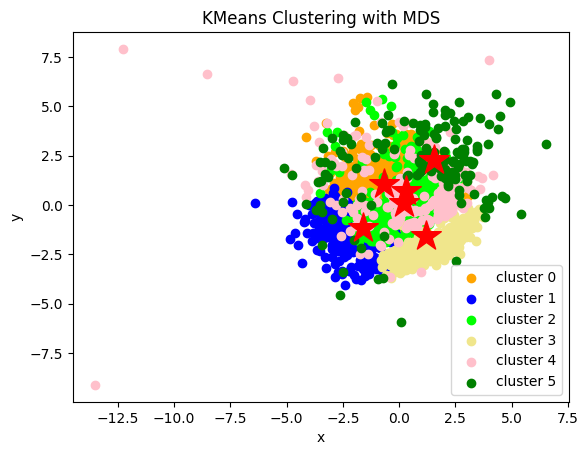

In [62]:
data_and_centers = np.r_[preprocessed_data, cluster_centers]

# apply MDS to the combined data
XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(data_and_centers)
print("Transformation complete")

# Determine the number of points in XYcoordinates.
n_points = XYcoordinates.shape[0]

# use clustering scatterplot function to visualize the clusters
clustering_scatterplot(points=XYcoordinates[:-k, :], 
                       labels=cluster_labels[:n_points-k], 
                       centers=XYcoordinates[-k:, :], 
                       title="KMeans Clustering with MDS")

plt.show()

#### Step 5 - t-SNE Visualisation

t-SNE transformation complete


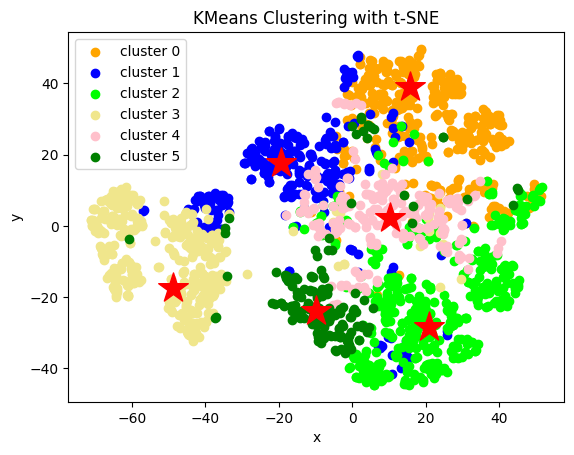

In [87]:
# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Combine the preprocessed data and cluster centers before applying t-SNE
combined_data = np.vstack([preprocessed_data, cluster_centers])

# Apply t-SNE to the combined data
tsne_results_combined = tsne.fit_transform(combined_data)

# Split the results back into data points and centers
tsne_data_points = tsne_results_combined[:-k]
tsne_centers = tsne_results_combined[-k:]

# No need for data_and_centers_tsne - just use the results directly
print("t-SNE transformation complete")

# Use clustering scatterplot function to visualize the clusters
clustering_scatterplot(points=tsne_data_points, 
                      labels=cluster_labels, 
                      centers=tsne_centers, 
                      title="KMeans Clustering with t-SNE")
plt.show()

#### Step 6 - Analyse clusters against subscribed status

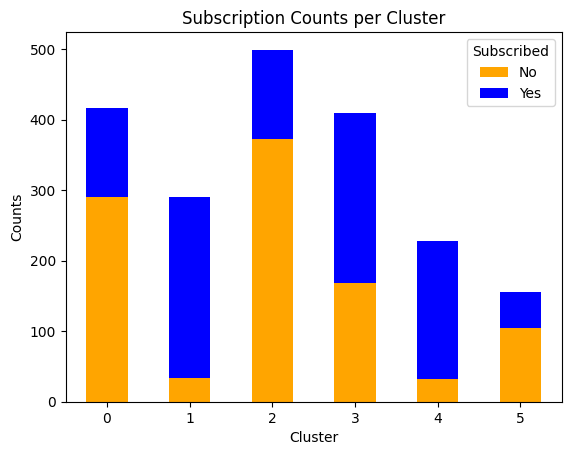

In [66]:
# plot subscription counts per cluster
def plot_subscription_counts(df):
    # Count the number of subscriptions in each cluster
    subscription_counts = df.groupby(['cluster', 'subscribed']).size().unstack(fill_value=0)
    
    # Plot the counts
    subscription_counts.plot(kind='bar', stacked=True, color=['orange', 'blue'])
    plt.title('Subscription Counts per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Counts')
    plt.xticks(rotation=0)
    plt.legend(title='Subscribed', labels=['No', 'Yes'])
    plt.show()


# Call the function to plot subscription counts
plot_subscription_counts(df)

#### Step 7 - Analyse clusters against other features

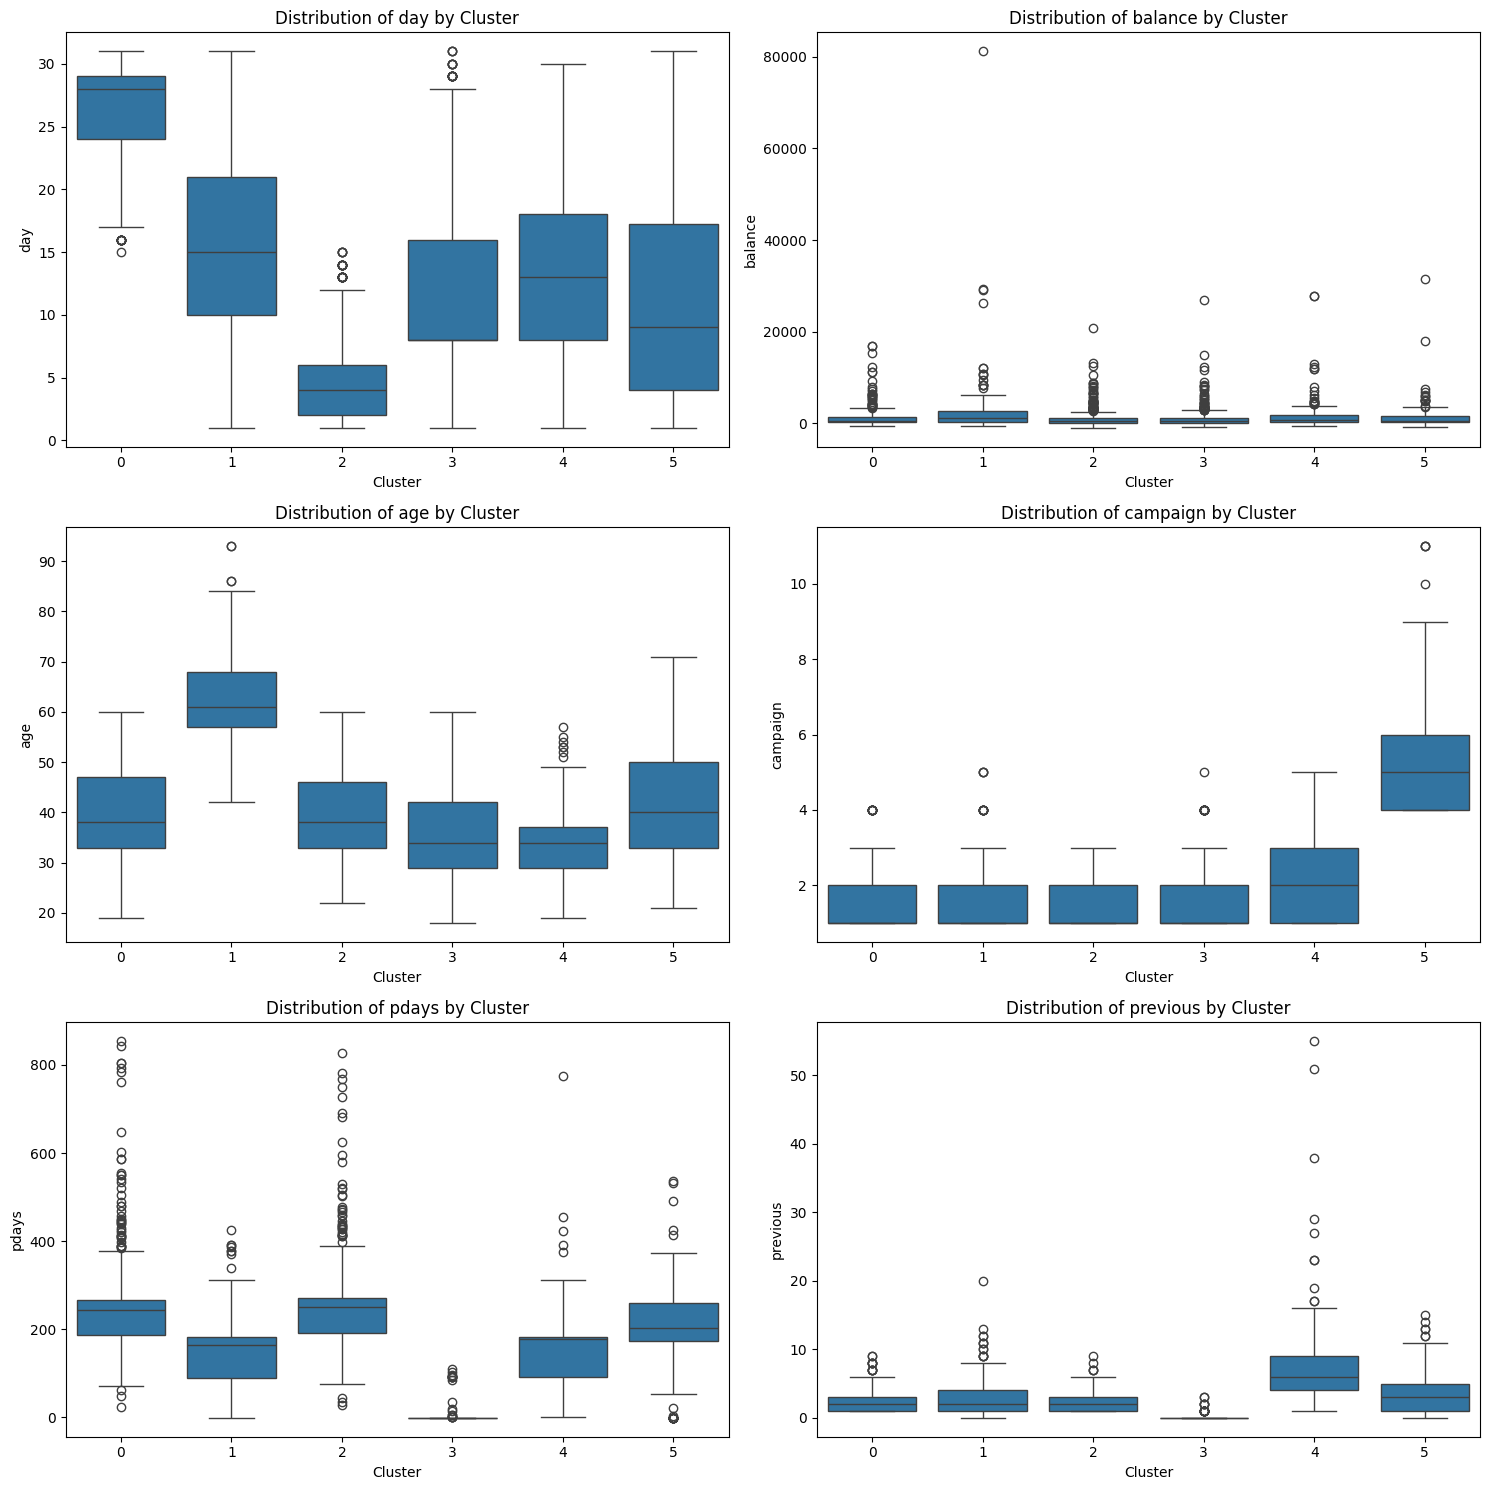

In [89]:
# plot the distribution of numerical features against clusters in a 3x2 grid
def plot_numerical_feature_distribution_grid(df, features):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        sns.boxplot(x='cluster', y=feature, data=df, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature} by Cluster')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel(feature)
    
    # Remove any unused subplots
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Call the function to plot numerical features
plot_numerical_feature_distribution_grid(df, numerical_features_to_plot)

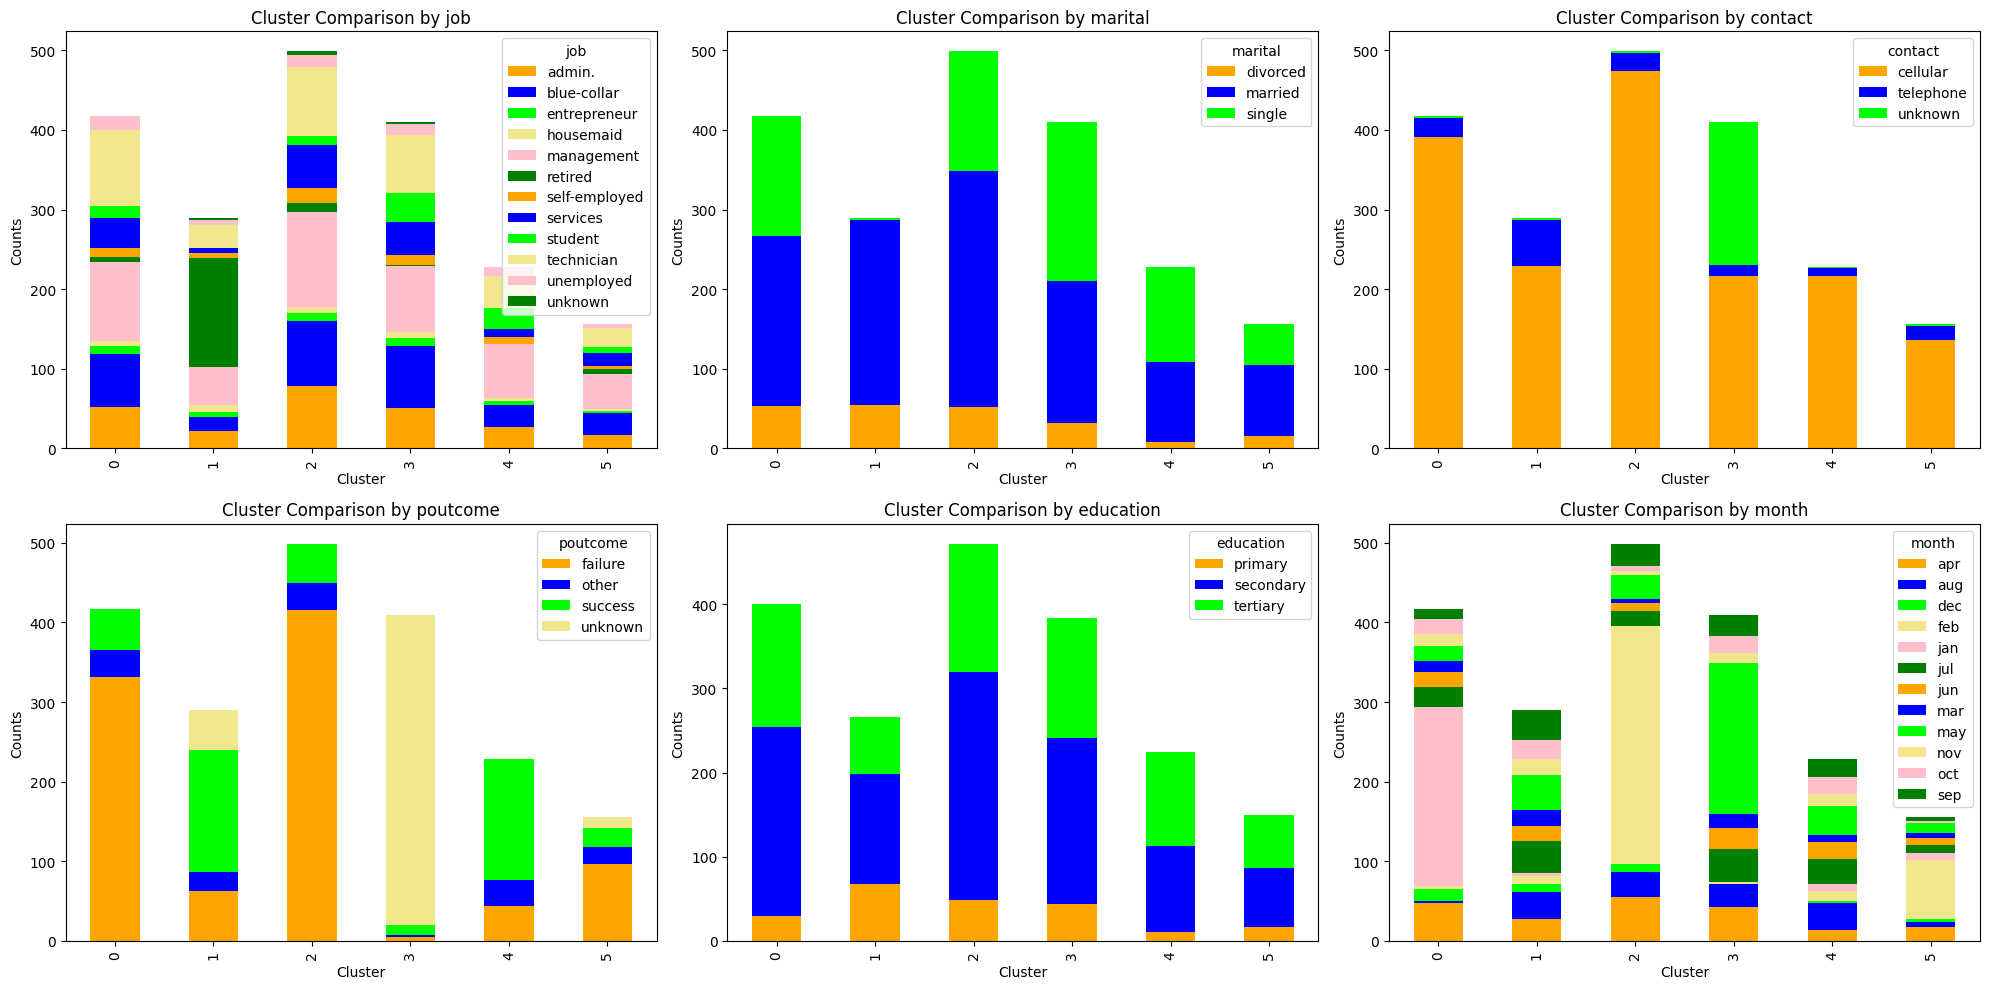

In [67]:
# List of features to compare
categorical_features_to_plot = ['job', 'marital', 'contact', 'poutcome', 'education', 'month']
numerical_features_to_plot = ['day', 'balance', 'age', 'campaign', 'pdays', 'previous']

# Create a 2x3 grid of subplots for categorical features
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

# Plot each categorical feature in a subplot
for i, feature in enumerate(categorical_features_to_plot):
    ax = axes[i]
    df.groupby(['cluster', feature]).size().unstack().plot(
        kind='bar', stacked=True, color=colors[:len(df['cluster'].unique())], ax=ax)
    ax.set_title(f'Cluster Comparison by {feature}')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Counts')
    ax.legend(title=feature, loc='upper right')

# Remove any unused subplots
for j in range(len(categorical_features_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Task 2 Conclusion

**Clusters vs target variable**

The bar plot indicates that the selected clusters possess some insight in relation to the subscription status.  Clusters 1 and 4 heavily lean towards the positive subscription 'yes', whereas cluster 2 and 0 favor 'No'.  The other 2 columns are more mixed but still add value.

**Clusters vs other features**

There are several interesting match ups here including:
* Numeric 
    * day - Cluster 0 contacts occur later in the month compared cluster 2 which is disticnly earlier
    * balance - Cluster 1 seems to capture people with higher balances.  It might explain why the same cluster tracks to positive subscriptions
    * age - Cluster 1 again seems to attract older people
    * campaign - Cluster 5 stands out with a higher number of contacts.  Combined with the low percentage of subscriptions, supports the previously made theory that over-contacting can drive subscriptions down.
* Categorical
    * job - cluster 1 has a large retired contingent, aligning with the age profile.
    * marital status - Cluster 1 has no single as we might expect of older demographic
    * contact type - cluster 3 seems to have captured all of the unknown values.  I am not sure what to make of this, possibly correlates with some aspect of how the data was collected.  Interesting in its own right
    * poutcome - tracks with current success rate, cluster 3 again dominated by unknown values
    * month - some clusters are dominated by single months, cluster 0 - October, cluster 2 - February.  This also aligns with previous correlations between positive subscriptions and the time of the year.

**Overall**
These clusters do a good job breaking out by target value and by several factors along demographic and behavioral lines.  They certainly seem to add value, whether as a standalone feature or combined with other features in further feature engineering.
    


## Task 3

In [ ]:
from itertools import product

def dbscan_grid_search(X, eps_values, min_samples_values):

    verbose = False

    results = []
    best_score = -1
    best_config = None

    for eps, min_samples in product(eps_values, min_samples_values):
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X)
        unique_labels = set(labels)
        n_clusters = len(unique_labels - {-1})

        if n_clusters < 2:
            if verbose:
                print(f"Skipped (eps={eps}, min_samples={min_samples}) — only {n_clusters} cluster(s)")
            continue

        # Filter out noise
        mask = labels != -1
        try:
            score = silhouette_score(X[mask], labels[mask])
        except Exception as e:
            if verbose:
                print(f"Error calculating silhouette (eps={eps}, min_samples={min_samples}): {e}")
            continue

        result = {
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'silhouette_score': score
        }
        results.append(result)

        if verbose:
            print(f"Tested (eps={eps}, min_samples={min_samples}) → Clusters: {n_clusters}, Silhouette: {score:.3f}")

        if score > best_score:
            best_score = score
            best_config = result

    return best_config, results

# Define the range of eps and min_samples values to test
eps_values = np.arange(0.1, 2.0, 0.1)
min_samples_values = np.arange(1, 50, 1)
# Run the grid search
best_config, results = dbscan_grid_search(preprocessed_data, eps_values, min_samples_values)
# Print the best configuration
print("\nBest Configuration:")
print(f"eps: {best_config['eps']}, min_samples: {best_config['min_samples']}, silhouette_score: {best_config['silhouette_score']:.3f}")




Tested (eps=0.1, min_samples=1) → Clusters: 1959, Silhouette: 0.024
Tested (eps=0.1, min_samples=2) → Clusters: 26, Silhouette: 0.858
Tested (eps=0.1, min_samples=3) → Clusters: 7, Silhouette: 0.867
Tested (eps=0.1, min_samples=4) → Clusters: 6, Silhouette: 0.859
Skipped (eps=0.1, min_samples=5) — only 0 cluster(s)
Error calculating silhouette (eps=0.1, min_samples=5): Found array with 0 sample(s) (shape=(0, 31)) while a minimum of 1 is required.
Tested (eps=0.1, min_samples=5) → Clusters: 0, Silhouette: 0.859
Skipped (eps=0.1, min_samples=6) — only 0 cluster(s)
Error calculating silhouette (eps=0.1, min_samples=6): Found array with 0 sample(s) (shape=(0, 31)) while a minimum of 1 is required.
Tested (eps=0.1, min_samples=6) → Clusters: 0, Silhouette: 0.859
Skipped (eps=0.1, min_samples=7) — only 0 cluster(s)
Error calculating silhouette (eps=0.1, min_samples=7): Found array with 0 sample(s) (shape=(0, 31)) while a minimum of 1 is required.
Tested (eps=0.1, min_samples=7) → Clusters: 0

In [163]:
# Define a pipeline for DBSCAN using preprocessed_data



dbscan_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dbscan', DBSCAN(eps=best_config['eps'], min_samples=best_config['min_samples'] ))
])
# Fit the DBSCAN model  
dbscan_model = dbscan_pipeline.fit(features)

dbscan_labels = dbscan_model['dbscan'].labels_
df['dbscan_cluster'] = dbscan_labels

# Check the number of unique labels (excluding noise) before calculating silhouette score
unique_labels = set(dbscan_labels) - {-1}  # Exclude noise (-1)
if len(unique_labels) >= 2:
    dbscan_silhouette_score = silhouette_score(preprocessed_data, dbscan_labels)
    print(f"Silhouette score for DBSCAN: {dbscan_silhouette_score:.4f}")
else:
    print("Silhouette score cannot be calculated: less than 2 clusters.")

# Only include clustered points (exclude noise)
mask = dbscan_labels != -1

# count dbscan_labels where equal to -1
noise_points_count = np.sum(dbscan_labels == -1)
print(f"Number of noise points in DBSCAN: {noise_points_count} out of {len(dbscan_labels)}")

masked_data = preprocessed_data[mask]
masked_labels = dbscan_labels[mask]
print(masked_data.shape)
print(masked_labels.shape)

if len(set(masked_labels)) >= 2:
    score = silhouette_score(masked_data, masked_labels)
    print(f"Silhouette score for DBSCAN (excluding noise): {score:.4f}")
else:
    print("Silhouette score cannot be calculated for clustered points: less than 2 clusters.")

Silhouette score for DBSCAN: -0.0776
Number of noise points in DBSCAN: 1974 out of 2000
(26, 31)
(26,)
Silhouette score for DBSCAN (excluding noise): 0.8732


DBSCAN MDS transformation complete


DBSCAN MDS transformation complete


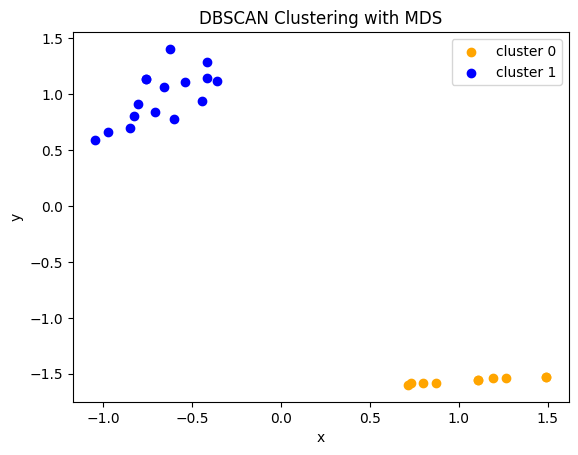

In [167]:
# apply manifold MDS to the dbscan clustered data
dbscan_coordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(masked_data)
print("DBSCAN MDS transformation complete")

# use clustering scatterplot function to visualize the clusters
clustering_scatterplot(points=dbscan_coordinates, 
                       labels=masked_labels, 
                       centers=None, 
                       title="DBSCAN Clustering with MDS")
plt.show()


t-SNE transformation complete


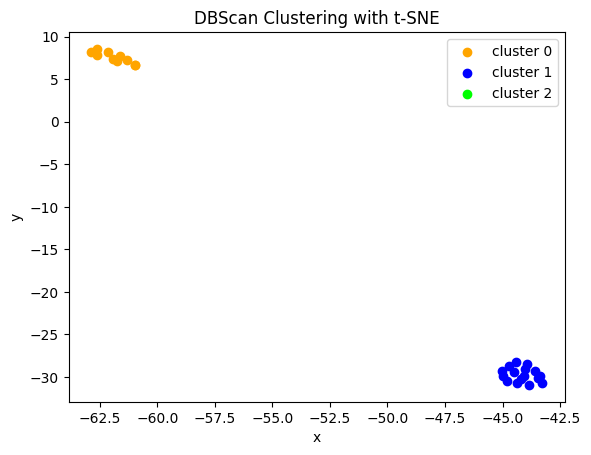

In [164]:


# Apply t-SNE to the combined data
tsne_results_combined = tsne.fit_transform(combined_data)

# Split the results back into data points and centers
tsne_data_points = tsne_results_combined[:-k]


# No need for data_and_centers_tsne - just use the results directly
print("t-SNE transformation complete")

# Use clustering scatterplot function to visualize the clusters
clustering_scatterplot(points=tsne_data_points, 
                      labels=dbscan_labels, 
                      centers=None, 
                      title="DBScan Clustering with t-SNE")
plt.show()


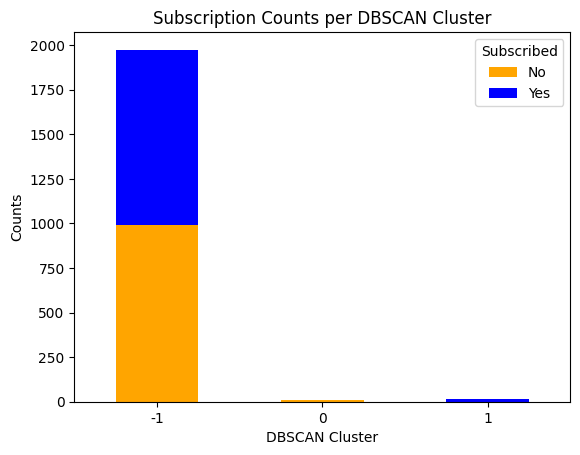

In [165]:
# plot subscription counts per cluster for DBSCAN
def plot_subscription_counts_dbscan(df):
    # Count the number of subscriptions in each cluster
    subscription_counts = df.groupby(['dbscan_cluster', 'subscribed']).size().unstack(fill_value=0)
    
    # Plot the counts
    subscription_counts.plot(kind='bar', stacked=True, color=['orange', 'blue'])
    plt.title('Subscription Counts per DBSCAN Cluster')
    plt.xlabel('DBSCAN Cluster')
    plt.ylabel('Counts')
    plt.xticks(rotation=0)
    plt.legend(title='Subscribed', labels=['No', 'Yes'])
    plt.show()

# Call the function to plot subscription counts for DBSCAN
plot_subscription_counts_dbscan(df)

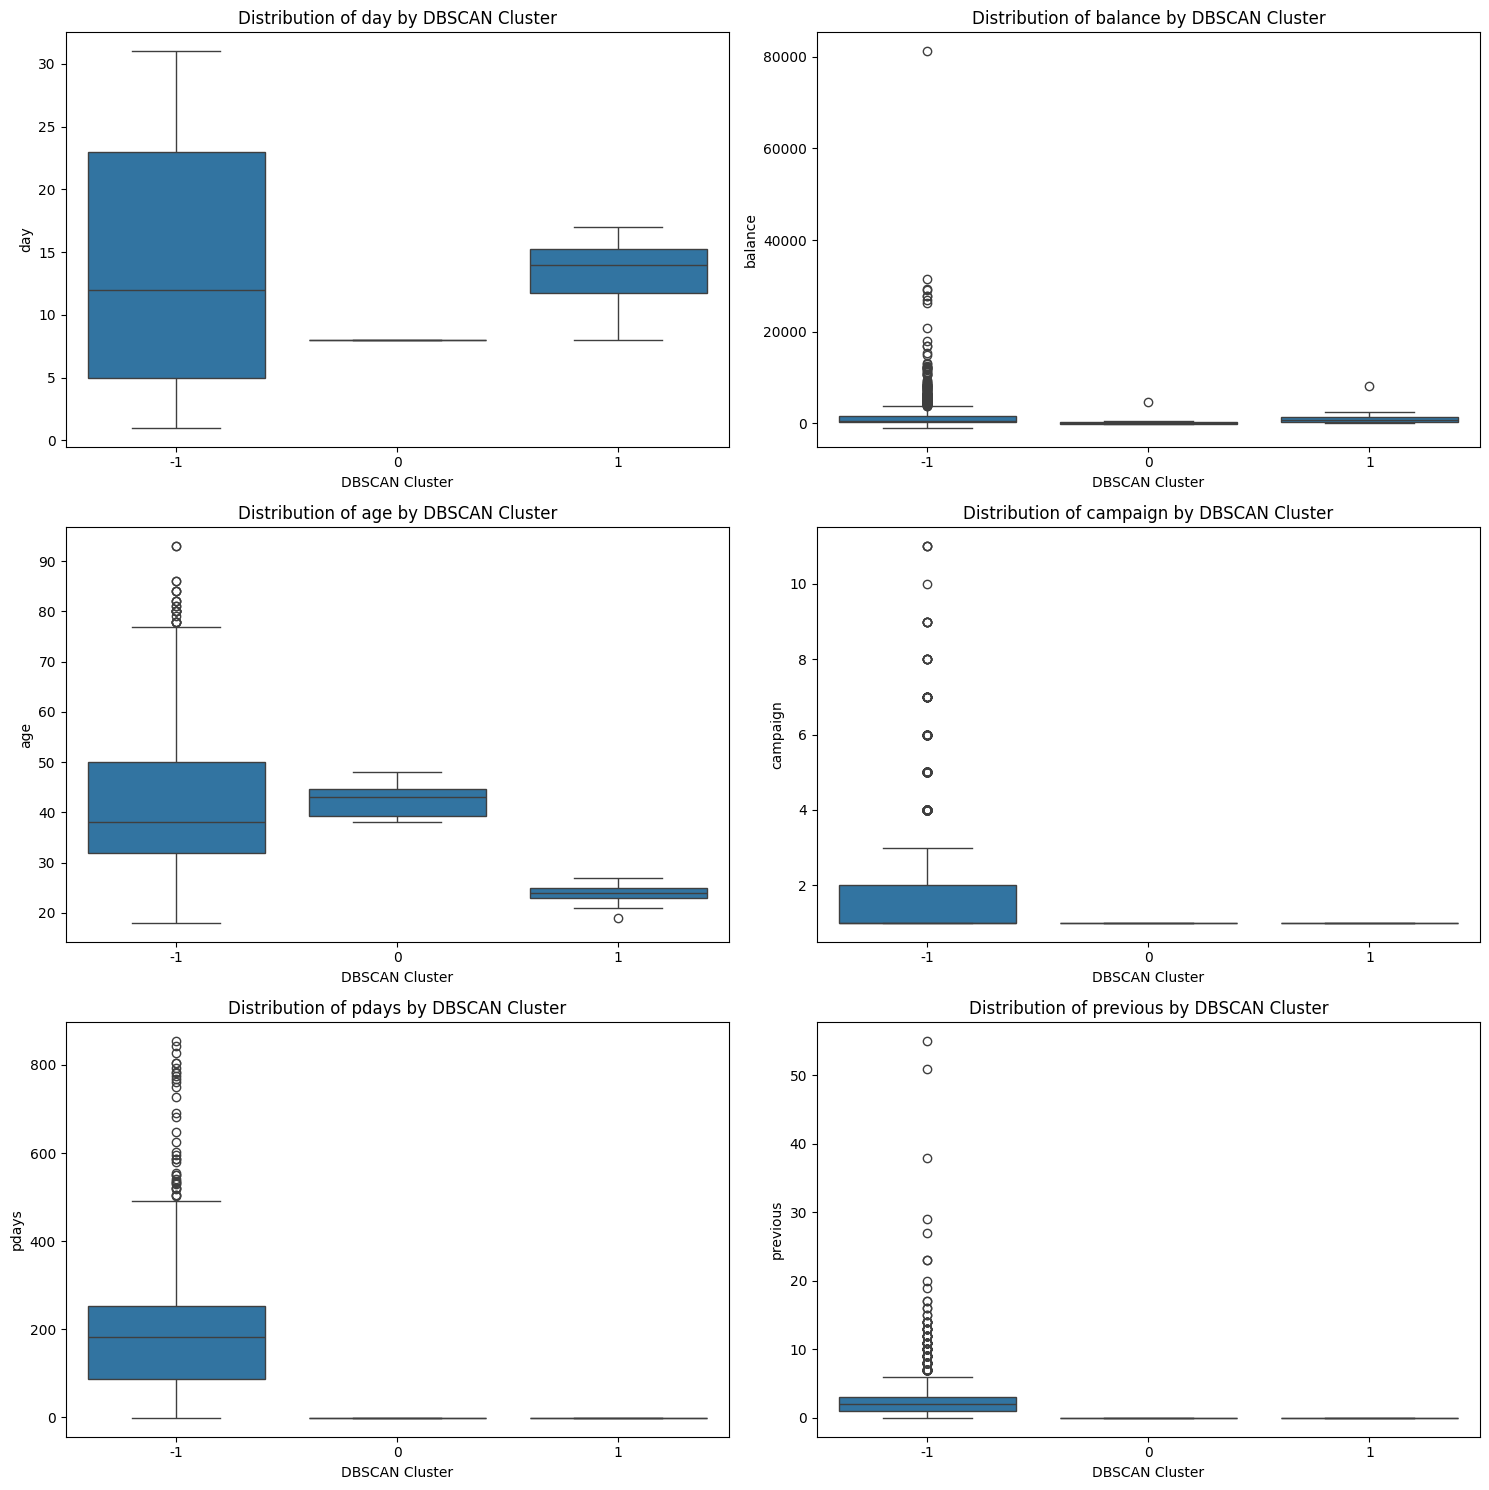

In [166]:
# plot the distribution of numerical features against clusters in a 3x2 grid for DBSCAN
def plot_numerical_feature_distribution_grid_dbscan(df, features):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        sns.boxplot(x='dbscan_cluster', y=feature, data=df, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature} by DBSCAN Cluster')
        axes[i].set_xlabel('DBSCAN Cluster')
        axes[i].set_ylabel(feature)
    
    # Remove any unused subplots
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Call the function to plot numerical features for DBSCAN
plot_numerical_feature_distribution_grid_dbscan(df, numerical_features_to_plot)